# Bitcoin prices and the shape of the globe

[Why Bitcoin price is increasing amid Russia-Ukraine war](https://www.financialexpress.com/digital-currency/why-bitcoin-price-is-increasing-amid-russia-ukraine-war/2447933/)

**¿Which could be the bitcoin price next week?**


Read bitcoin data

In [2]:
using CSV
using DataFrames

dataBitcoin = CSV.read("Bitcoin.csv",DataFrame);
dataBitcoin.Price .= replace.(dataBitcoin.Price, "," => "");
dataBitcoin.PriceFloat = parse.(Float64, dataBitcoin.Price);

In [4]:
dataBitcoin.Price

29-element Vector{String15}:
 "38014.8"
 "38403.1"
 "39395.8"
 "39142.7"
 "42463.0"
 "43912.8"
 "44420.3"
 "43188.2"
 "37689.1"
 "39115.5"
 "39209.6"
 "38339.2"
 "37224.6"
 ⋮
 "40000.1"
 "40552.8"
 "43883.6"
 "44544.4"
 "42550.3"
 "42061.1"
 "42205.2"
 "42388.4"
 "43521.0"
 "44388.9"
 "44038.2"
 "43833.9"

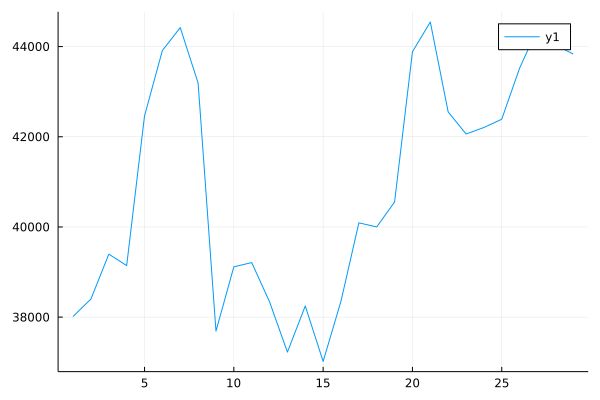

In [2]:
using Plots

plot(dataBitcoin.PriceFloat)

Least squares formulation:

$\tilde{x} = \mbox{arg min}_{x} \| Ax - b \|_2^2$

In [5]:
N = size(dataBitcoin.PriceFloat,1);
A = Array((1:N));
b = Array(dataBitcoin.PriceFloat);
A = [ones(N,1) A];
println(A)
println(b)
println(N)

[1.0 1.0; 1.0 2.0; 1.0 3.0; 1.0 4.0; 1.0 5.0; 1.0 6.0; 1.0 7.0; 1.0 8.0; 1.0 9.0; 1.0 10.0; 1.0 11.0; 1.0 12.0; 1.0 13.0; 1.0 14.0; 1.0 15.0; 1.0 16.0; 1.0 17.0; 1.0 18.0; 1.0 19.0; 1.0 20.0; 1.0 21.0; 1.0 22.0; 1.0 23.0; 1.0 24.0; 1.0 25.0; 1.0 26.0; 1.0 27.0; 1.0 28.0; 1.0 29.0]
[38014.8, 38403.1, 39395.8, 39142.7, 42463.0, 43912.8, 44420.3, 43188.2, 37689.1, 39115.5, 39209.6, 38339.2, 37224.6, 38248.2, 37017.7, 38355.0, 40090.3, 40000.1, 40552.8, 43883.6, 44544.4, 42550.3, 42061.1, 42205.2, 42388.4, 43521.0, 44388.9, 44038.2, 43833.9]
29


Plot the **objective function**:

In [6]:
using Plots

function f(x,y) 
    sum((A[:,1]*x+A[:,2]*y-b)*transpose((A[:,1]*x+A[:,2]*y-b)))
end
plotlyjs()
surface(-50000:1000:50000,-10000:100:15000, f)

WebIO._IJuliaInit()

Least squares solution:

$\tilde{x} = \mbox{arg min}_{x} J(\mathbf x) = \mbox{arg min}_{x} \| Ax - b \|_2^2$

$J(x) = \| Ax - b\|_2^2 = ( Ax - b )^T ( Ax - b ) = (A x)^T (A x) - (A x)^T b - b^T (A x) + b^T b$

$J(x) = x^T A^T Ax - 2 x^T A^T b + b^T b$

Now **minimizing** $J(x)$ w.r.t $x$:

$\frac{\partial J(x)}{\partial  x} = - 2 A^T b + 2 A^T A x = 0$

We obtain the [normal equations](https://en.wikipedia.org/wiki/Linear_least_squares#Derivation_of_the_normal_equations):

$A^T A x = A^T b$

The solution:

$x = (A^T A)^{-1} A^T  b = A^+ b$

With $A^+ = (A^T A)^{-1} A^T$ the Moore-Penrose pseudoinverse of $A$.

# Arrange data to compute least squares

Structure data to compute least squares:

## Least solution Squares in Julia

https://www.matecdev.com/posts/julia-least-squares-qr.html

* Using the unique least squares approximate solution of overdetermined equations:

$(A^T A)^{-1} A^T$y

In [7]:
transpose(A)*A

2×2 Matrix{Float64}:
  29.0   435.0
 435.0  8555.0

In [8]:
beta1 = inv(transpose(A)*A)*(transpose(A)*b)

2-element Vector{Float64}:
 38722.227832512275
   150.00733990147995

* Using the Moore-Penrose pseudoinverse:

In [7]:
using LinearAlgebra

xhat2 = pinv(A)*b

2-element Vector{Float64}:
 38722.22783251229
   150.0073399014777

* Solving the normal equations:

$A^T A x = A^T b$


In [ ]:
x = transpose(A)*A \ transpose(A)*b

2-element Vector{Float64}:
 38722.227832512304
   150.00733990147774

* Using the QR solution:

In [8]:
using LinearAlgebra
xhat3 = A\b

2-element Vector{Float64}:
 38722.227832512304
   150.00733990147825

* There are cases where we want to obtain and store the matrices Q and R from the factorization:

In [9]:
qrA = qr(A);                    # QR decomposition
xhat4 = qrA\b

2-element Vector{Float64}:
 38722.22783251231
   150.00733990147765

In [10]:
using Plots

xhat = xhat4

pred = xhat[2]*A[:,2] + xhat[1]*ones(N,1)
plot(A[:,2],b)
plot!(A[:,2],pred)


## Fitting an ellipse as Meyer (non-linear models)

Let’s focus in an interesting curve-fitting problem, where we are given $n$ pairs of points 
$x_i,y_i$ and we want to find the ellipse which provides the best fit.

An idea can be start with the general conic that should satisfy this model:

$a x^2 + bxy + c y^2 + dx + ey + f = 0$

(Note that this is a second order equation, that will be quite important later in the course)

This model can be alternatively formulated as:

$a x^2 + bxy + c y^2 + dx + ey = 1$

Points in a particular ellipse should "satisfy" this equation (model). A particular ellipse (model) is parametrized by specific values of $a,b,c,d,e$. 

Therefore, given a set of observations $\{(x_i,y_i)_1^n\}$ the problem is find $a,b,c,d,e$ such that the following set of equations are satisfied:

$a x_i^2 + b x_i y_i + c y_i^2 + dx_i + ey_i = 1 \qquad 1 \le i \le n$

This problem can be formulated as a least squares problem by specifying a proper design matrix $A$, and solve the problem by using the previous formulation.

Let's generate noisy  points points around the ellipse.

In [11]:
θ = π/7; a = 2; b = 1.5; x_0 = 3; y_0 = -1;
fx(t) = a*cos(θ)*cos(t) - b*sin(θ)*sin(t) + x_0
fy(t) = a*sin(θ)*sin(t) + b*cos(θ)*cos(t) + y_0

N = 200;
ts = LinRange(0,2π,N);
x = fx.(ts) + randn(N)*0.1;
y = fy.(ts) + randn(N)*0.1;

Now we can construct the design matrix.

In [12]:
A = [x.^2 y.^2 x.*y x y ]

200×5 Matrix{Float64}:
 21.6362  0.216038     2.162      4.65148   0.464799
 23.6681  0.13087      1.75996    4.86499   0.36176
 23.1809  0.172398     1.99908    4.81465   0.415208
 24.0339  0.105236     1.59036    4.90244   0.324401
 23.1005  0.394058     3.01711    4.8063    0.62774
 21.2375  0.369397     2.80091    4.60842   0.607781
 22.2909  0.427445     3.08677    4.72132   0.653792
 20.5504  0.254361     2.28631    4.53325   0.504342
 21.0862  0.20398      2.07392    4.59197   0.451642
 20.4338  0.287287     2.42288    4.52038   0.535992
 18.4433  0.207258     1.95513    4.29457   0.455256
 19.6613  0.239871     2.17167    4.4341    0.489766
 19.0168  0.388407     2.71777    4.36082   0.623223
  ⋮                                        
 25.2247  2.24594e-5  -0.0238019  5.02242  -0.00473914
 23.959   0.0013737   -0.181418   4.8948   -0.0370635
 24.9258  0.084518     1.45144    4.99257   0.29072
 23.8376  0.00393526   0.30628    4.88238   0.0627316
 24.8695  0.0304928    0.870827

We solve the least square problem by using the QR decomposition.

In [13]:
p = A\ones(N)

5-element Vector{Float64}:
 -0.07876680640152253
 -0.10833098844875914
  0.1139965295575647
  0.5914264460946675
 -0.5641971069850461

In [14]:

using Convex, SCS

b_t = ones(N)

# Create a (column vector) variable of size n x 1.
x_t = Variable(size(A,2))

# The problem is to minimize ||Ax - b||^2
# This can be done by: minimize(objective, constraints)
problem = minimize(square(norm(A * x_t - b_t)))

# Solve the problem by calling solve!
solve!(problem, SCS.Optimizer; silent_solver = true)

# Check the status of the problem
problem.status # :Optimal, :Infeasible, :Unbounded etc.

# Get the optimum value
p = x_t.value

LoadError: ArgumentError: Package Convex not found in current path:
- Run `import Pkg; Pkg.add("Convex")` to install the Convex package.


We plot the solution:

In [13]:
using Plots
X = LinRange(minimum(x),maximum(x),100)
Y = LinRange(minimum(y),maximum(y),100)
F = Array{Float64}(undef,100,100)
for i in 1:100, j in 1:100
    F[i,j] = p[1]*X[i]^2 + p[2]*Y[j]^2 + p[3]*X[i]*Y[j] + p[4]*X[i] + p[5]*Y[j]
end

plot(x,y,seriestype = :scatter)
contour!(X, Y, F, linewidth=3, levels=[1], color=:green, label="Fitted Ellipse")
plot!(fx.(ts), fy.(ts), linewidth=3, color=:blue)
#plot!([], color=:green, label="Fitted Ellipse")

LoadError: ArgumentError: Package Plots not found in current path:
- Run `import Pkg; Pkg.add("Plots")` to install the Plots package.


# Homework 1

* Related with the nature of the data, which conditions should meet matrices $A$ and $b$ to be solvable from the least squares perspective.

* Use a least squares for non-linear models adjust the bitcoin price and perform a prediction using the model to determine the future daily price a week ahead, compare with the actual values.

* Use least squares to determine the relationship between the bitcoin price and prices of three comodities namely, oil, silved and gold, during the last year.

* Solve the [point set registration problem](https://en.wikipedia.org/wiki/Point-set_registration). Hint (check: S. Umeyama, Least-Squares Estimation of Transformation Parameters Between Two Point Patterns, IEEE Trans. Pattern Anal. Mach. Intell., vol. 13, no. 4, 1991). Construct a GUI to test.